In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
import os
os.environ['LANGSMITH_TRACING'] ="true"
os.environ["LANGSMITH_ENDPOINT"] =os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_API_KEY"] =os.getenv("LANGSMITH_API_KEY")
os.environ ["LANGSMITH_PROJECT"]=os.getenv("LANGSMITH_PROJECT")

In [46]:
from typing import Annotated, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0
)

In [48]:
from pydantic import BaseModel, Field
from typing import Literal

class MedicalSupervisor(BaseModel):
    next: Literal["rag_agent", "doctor_agent"] = Field(
        description=(
            "يحدد أي وكيل يجب تنشيطه بناءً على شدة حالة الإسعافات الأولية:\n"
            "- 'rag_agent' للحالات البسيطة التي يمكن الرد عليها تلقائيًا باستخدام RAG (استرجاع المعرفة)،\n"
            "- 'doctor_agent' للحالات التي تحتاج إلى استشارة طبيب أو تدخل طبي مباشر."
        )
    )
    reason: str = Field(
        description=(
            "تفسير تفصيلي لسبب توجيه السؤال، موضحًا لماذا تم اختيار rag_agent أو doctor_agent، "
            "مع مراعاة شدة الحالة، المخاطر، وتعقيد السيناريو الطبي."
        )
    )



In [49]:
llm.invoke('اهلا')

AIMessage(content='مرحبا. كيف يمكنني مساعدتك؟', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 37, 'total_tokens': 49, 'completion_time': 0.020148962, 'prompt_time': 0.002203012, 'queue_time': 0.089579698, 'total_time': 0.022351974}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--73be069d-c270-4888-afee-26ff26c34881-0', usage_metadata={'input_tokens': 37, 'output_tokens': 12, 'total_tokens': 49})

In [50]:
def medical_supervisor_node(state: MessagesState) -> Command[Literal["rag_agent", "doctor_agent"]]:

    system_prompt = '''
أنت مشرف طبي ذكي على فريق يتكون من وكيلين: RAG Agent و Doctor Agent. 
مهمتك هي توجيه كل سؤال من المستخدم إلى الوكيل الأنسب وفقًا لشدة الحالة واحتياجات المهمة، مع تقديم سبب مفصل لكل قرار.

**الوكلاء**:
1. **RAG Agent**: يجيب على الحالات البسيطة التي يمكن حلها بالإسعافات الأولية المنزلية، مثل الجروح الصغيرة، النزيف الخفيف، الحروق السطحية.
2. **Doctor Agent**: يتعامل مع الحالات الحرجة أو المعقدة التي تتطلب استشارة طبيب، مثل فقدان الوعي، الكسور، صعوبة التنفس، التسمم.

**مسؤولياتك**:
1. تحليل كل سؤال من المستخدم وفحص الإجابات السابقة للتأكد من الاكتمال والدقة والملاءمة.
2. توجيه المهمة إلى الوكيل الأنسب في كل مرحلة.
3. الحفاظ على سير العمل بكفاءة وتجنب التكرار.
4. متابعة العملية حتى يتم حل طلب المستخدم بشكل كامل ومرضي.

**أمثلة للحالات**:

**مثال 1:**  
المستخدم: "لدي خدش صغير في يدي ونزيف بسيط، ماذا أفعل؟"  
ردك:
{
  "next": "rag_agent",
  "reason": "الحالة عبارة عن خدش صغير مع نزيف بسيط يمكن التعامل معه في المنزل باستخدام الإسعافات الأولية دون الحاجة لتدخل طبي عاجل."
}

**مثال 2:**  
المستخدم: "صديقي فقد وعي بعد سقوطه، ماذا أفعل؟"  
ردك:
{
  "next": "doctor_agent",
  "reason": "الحالة حرجة بسبب فقدان الوعي ويجب التدخل الطبي فورًا. الإسعافات الأولية المنزلية غير كافية."
}

الآن قيّم السؤال الجديد وقدم الرد بصيغة JSON مطابقة للـ MedicalSupervisor.
'''

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(MedicalSupervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

In [51]:
res = llm.with_structured_output(MedicalSupervisor).invoke("صديقي فقد وعي بعد سقوطه،")


In [52]:
res

MedicalSupervisor(next='rag_agent', reason='فقد وعي صديقي بعد سقوطه، مما يحتاج إلى استجابة سريعة ومتاحة للاستشارة الطبية.')

In [53]:
from twilio.rest import Client
account_sid = "AC93a462e47317fa56f791d2c862d2753e"
auth_token = "8ae04b015ad5e93ff2b21fb0baf437ca"
client = Client(account_sid, auth_token)

def send_whatsapp(to: str, body: str):
    message = client.messages.create(
        from_="whatsapp:+14155238886",   
        to=f"whatsapp:{to}",            
        body=body
    )
    return f" SID : {message.sid}"

def doctor_agent_node(state: MessagesState) -> Command[Literal["end"]]:
    messages = state["messages"]
    reason_msg = next(
        (m.content for m in reversed(messages) if getattr(m, "name", "") == "supervisor"),
        "لم يتم العثور على سبب"
    )

    patient_number = state.get("patient_number", "+201557337866")

    try:
        sid = send_whatsapp(patient_number, reason_msg)
        print(f"--- WhatsApp Message Sent ---\nSID: {sid}")
    except Exception as e:
        print("Error sending WhatsApp message:", str(e))

    return Command(
        update={},
        goto="end"
    )

In [54]:
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [55]:
path="data.pdf"

In [56]:
!pip -q install langchain langchain_community langchain_google_genai chromadb tiktoken langgraph pdfplumber

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, MessagesState, add_messages

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
loader = PyPDFLoader(path)
docs = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", "؟", "!", "؛", "،", " "],
    length_function=len,
    is_separator_regex=False,
)
splits = text_splitter.split_documents(docs)

In [59]:
embeddings = HuggingFaceEmbeddings(model_name="aubmindlab/bert-base-arabertv02")
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)
retriever = vectorstore.as_retriever()

No sentence-transformers model found with name aubmindlab/bert-base-arabertv02. Creating a new one with mean pooling.


In [60]:
SYSTEM_TEMPLATE = """
أنت مساعد افتراضي تجيب فقط من كتاب "الإسعافات الأولية عربي مصور".
- إذا وُجدت معلومات في {context} مرتبطة بالسؤال، قدم إجابة واضحة وبسيطة منها.
- إذا لم تجد أي معلومة مرتبطة داخل {context}، رد فقط: لا أعرف
- لا تستخدم أي مصادر أو تخمينات خارج الكتاب.
 {context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_TEMPLATE)
])

In [61]:
from langchain.chains import RetrievalQA

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt}
)

In [62]:
def rag_agent(state: MessagesState) -> Command:
    last_msg = state["messages"] 
    question = last_msg 
    
    answer = rag_chain.invoke(question)
    answer={"question":answer}
    return Command(
        update={"messages":[ HumanMessage(content=answer)]},
        goto=None 
    )


In [63]:
graph = StateGraph(MessagesState)

# Nodes
graph.add_node("supervisor", medical_supervisor_node)
graph.add_node("doctor_agent", lambda state: doctor_agent_node(state))
graph.add_node("rag_agent", rag_agent)

# Edge
graph.add_edge(START, 'supervisor') 

# Compile
app = graph.compile()


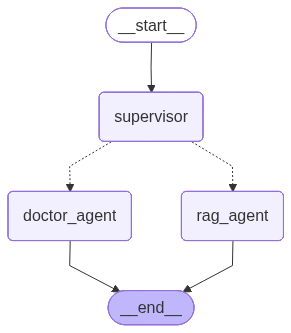

In [64]:
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 


In [65]:
inputs = {
    "messages": [
        ("user", "صديقي فقد وعي بعد سقوطه،"),
    ]
}

app.invoke(inputs)

--- Workflow Transition: Supervisor → DOCTOR_AGENT ---


Task doctor_agent with path ('__pregel_pull', 'doctor_agent') wrote to unknown channel branch:to:end, ignoring it.


--- WhatsApp Message Sent ---
SID:  SID : SMe899aca811f92b6eacf4c1128c509101


{'messages': [HumanMessage(content='صديقي فقد وعي بعد سقوطه،', additional_kwargs={}, response_metadata={}, id='82aa7359-0487-417b-b55b-326cddb1bd12'),
  HumanMessage(content='الحالة حرجة بسبب فقدان الوعي ويجب التدخل الطبي فورًا. الإسعافات الأولية المنزلية غير كافية.', additional_kwargs={}, response_metadata={}, name='supervisor', id='8977f808-f0ce-4709-a126-371a6a3275d9')]}

In [66]:
inputs = {
    "messages": [
        {"role": "user", "content": "لدي خدش صغير في يدي ونزيف بسيط"}
    ]
}
app.invoke(inputs)

--- Workflow Transition: Supervisor → RAG_AGENT ---


AttributeError: 'list' object has no attribute 'replace'